# Python implementation of the Kneedle algorithm
Finding a “Kneedle” in a Haystack: Detecting Knee Points in System Behavior  
Ville Satopa, Jeannie Albrecht, David Irwin, and Barath Raghavan  
https://www1.icsi.berkeley.edu/~barath/papers/kneedle-simplex11.pdf

In [2]:
import numpy as np
import scipy

import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
from kneed import KneeLocator
import numpy as np
import matplotlib.pyplot as plt

x = [ 1, 2, 3, 4, 5, 6 ]
y = [ -481., 783., 1019., 1158., 1224., 1293. ]

kneedle = KneeLocator(x[:4], y[:4], S=1.0, curve='concave', direction='increasing')

/Users/kevin/projects/kneed/kneed/knee_locator.py:171: UserWarning: No knee/elbow found
  warnings.warn('No knee/elbow found')


ValueError: min() arg is an empty sequence

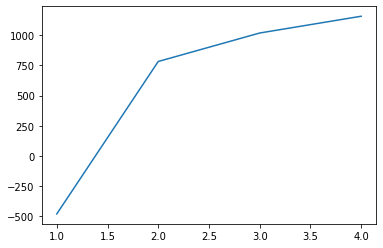

In [14]:
plt.plot(x[:4], y[:4]);

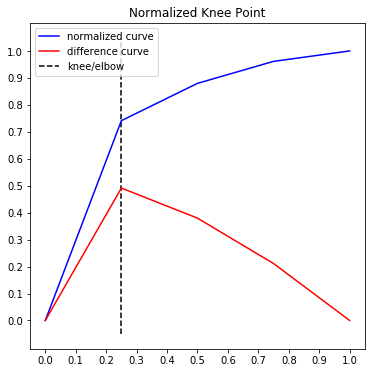

In [12]:
kneedle.plot_knee_normalized()

# Finding the knee from figure 2 from the paper

In [2]:
def figure2():
    x = np.linspace(0.0, 1, 10)
    with np.errstate(divide='ignore'):
        return x,np.true_divide(-1, x + 0.1) + 5

# Step 0:  Raw input

In [3]:
x,y = figure2()

In [4]:
if not np.array_equal(np.array(x), np.sort(x)):
    raise ValueError('x needs to be sorted')

# Step 1: Fit a spline

In [5]:
from scipy.interpolate import interp1d

In [6]:
N = len(x)

In [7]:
# Ds = the finite set of x- and y-values that define a smooth curve, 
# one that has been fit to a smoothing spline.
uspline = interp1d(x, y)
Ds_y = uspline(x)

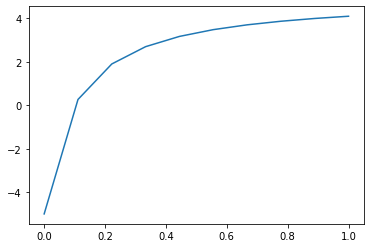

In [8]:
plt.plot(x, Ds_y);

# Step 2: Normalize the spline

In [9]:
def normalize(a):
    """return the normalized input array"""
    return (a - min(a)) / (max(a) - min(a))

In [10]:
# x and y normalized to unit square
x_normalized = normalize(x)
y_normalized = normalize(Ds_y)

# Step 3: Calculate the difference curve

In [11]:
# the difference curve
y_distance = y_normalized - x_normalized
x_distance = x_normalized.copy()

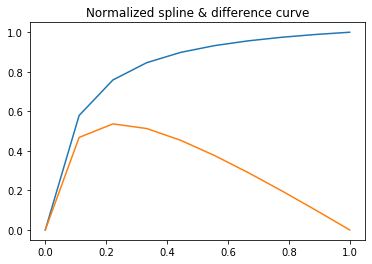

In [12]:
plt.title("Normalized spline & difference curve");
plt.plot(x_normalized, y_normalized);
plt.plot(x_distance, y_distance);

# Step 4: Identify local maxima  
of the difference curve

In [13]:
from scipy.signal import argrelextrema

In [14]:
# local maxima for knees
maxima_inidices = argrelextrema(y_distance, np.greater)[0]
x_distance_maxima = x_distance[maxima_inidices]
y_distance_maxima = y_distance[maxima_inidices]

# local minima
minima_indices = argrelextrema(y_distance, np.less)[0]
x_distance_minima = x_distance[minima_indices]
y_distance_minima = y_distance[minima_indices]

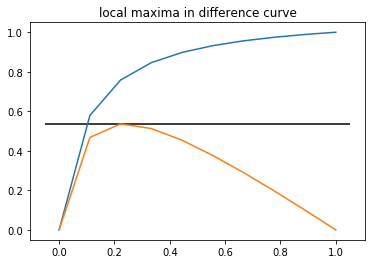

In [15]:
plt.title("local maxima in difference curve");
plt.plot(x_normalized, y_normalized);
plt.plot(x_distance, y_distance);
plt.hlines(y_distance_maxima, plt.xlim()[0], plt.xlim()[1]);

# Step 5: Calculate thresholds

In [16]:
# Sensitivity parameter S
# smaller values detect knees quicker
S = 1.0

In [17]:
Tmx = y_distance_maxima - (S * np.abs(np.diff(x_normalized).mean()))

# Step 6: knee finding algorithm

If any difference value (xdj, ydj), where j > i, drops below the threshold y = T|mxi
for (x|mxi, y|mxi) before the
next local maximum in the difference curve is reached,
Kneedle declares a knee at the x-value of the corresponding
local maximum x = x|xi.  
**If the difference values reach
a local minimum and starts to increase before y = T|mxi
is reached, we reset the threshold value to 0 and wait for
another local maximum to be reached.**

In [18]:
# artificially place a local max at the last item in the x_distance array
maxima_inidices = np.append(maxima_inidices, len(x_distance) - 1)
minima_indices = np.append(minima_indices, len(x_distance) - 1)

# placeholder for which threshold region i is located in.
maxima_threshold_index = 0
minima_threshold_index = 0

curve = 'concave'
direction = 'increasing'

all_knees = set()
all_norm_knees = set()

# traverse the distance curve
for idx, i in enumerate(x_distance):

    # reached the end of the curve
    if i == 1.0:
        break

    # values in distance curve are at or after a local maximum
    if idx >= maxima_inidices[maxima_threshold_index]:
        threshold = Tmx[maxima_threshold_index]
        threshold_index = idx
        maxima_threshold_index += 1

    # values in distance curve are at or after a local minimum
    if idx >= minima_indices[minima_threshold_index]:
        threshold = 0.0
        minima_threshold_index += 1

    # Do not evaluate values in the distance curve before the first local maximum.
    if idx < maxima_inidices[0]:
        continue

    # evaluate the threshold
    if y_distance[idx] < threshold:
        if curve == 'convex':
            if direction == 'decreasing':
                knee = x[threshold_index]
                all_knees.add(knee)
                norm_knee = x_normalized[threshold_index]
                all_norm_knees.add(norm_knee)
            else:
                knee = x[-(threshold_index + 1)]
                all_knees.add(knee)
                norm_knee = x_normalized[-(threshold_index + 1)]
                all_norm_knees.add(norm_knee)

        elif curve == 'concave':
            if direction == 'decreasing':
                knee = x[-(threshold_index + 1)]
                all_knees.add(knee)
                norm_knee = x_normalized[-(threshold_index + 1)]
                all_norm_knees.add(norm_knee)
            else:
                knee = x[threshold_index]
                all_knees.add(knee)
                norm_knee = x_normalized[threshold_index]
                all_norm_knees.add(norm_knee)

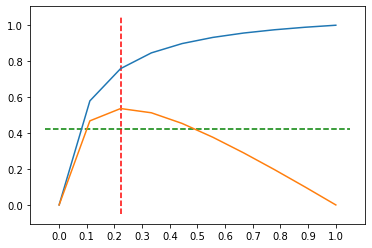

In [19]:
plt.xticks(np.arange(0,1.1,0.1))
plt.plot(x_normalized, y_normalized);
plt.plot(x_distance, y_distance);
plt.hlines(Tmx[0], plt.xlim()[0], plt.xlim()[1], colors='g', linestyles='dashed');
plt.vlines(x_distance_maxima, plt.ylim()[0], plt.ylim()[1], colors='r', linestyles='dashed');

The vertical, red dashed line represents the x value of the knee point. The horizontal greeb dashed line represents the threshold value.

In [20]:
knee

0.2222222222222222

In [21]:
# normalized x value where the knee was determined
norm_knee

0.2222222222222222